# KNN-1: train with partial curves 

My idea is to used one of the partial cycle files to train the KNN model. For that, I need to get the distances between each of the partial curves with all the full curves. So for each partial curve, choose the closer full curve.
The result is an array with all the distances for each partial cycle. The number of cycle is the label of each distance.
With that i train the model.

Then, the user will give us a curve. We need to get first the distance of this curve to all our full curves and get the closer one.
That distance is what i feed the model to make a prediction of the cycle number.

We can used one file of partial curves as train set and then other as test set.

**I tried to do this, but the code for getting the distance for each partial curve takes FOREVER!. So i only used 2 partial curves to train. Of course this is not okey, but i just wanted to see if this made any sense**

### Victor's comments

So what we're actually doing is we're looking at just the voltage curves. What we're going feeding into dtw is actually just the voltage data. These don't need to be of the same length I think. They just have to end and start at the same voltage so that our comparison and time-region estimation is better... Also, just to be safe, I also made the partial data curves to only be every 10 seconds remaking the matrix to be every other point (so 10 s intervals vs 5)



In [1]:
import pandas as pd
import numpy as np
import import_data
import sort_data
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

%matplotlib inline

/Users/rossana13/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#Load the data. We need full curves and one partial curve (that represents the user's curve)

PL03c,PL03d = sort_data.charge_discharge('converted_PL03.mat')
full_curvesc,full_curvesd = sort_data.charge_discharge('converted_PL11.mat')

#PL10c,PL10d = sort_data.charge_discharge('data/converted_PL10.mat')

In [3]:
a = PL03d[444]['voltage'].values.flatten()
b = full_curvesd[2][['voltage']].values.flatten()

In [4]:
print(len(a),len(b))

801 693


In [5]:
a_max = a.max()
a_min = a.min()

b_max = np.argwhere(b < a_max)[0][0]
b_min = np.argwhere(b > a_min)[-1][0]

b = b[int(b_max):int(b_min)]

In [6]:
print(a_max,a_min)

3.8268837928771973 2.749699354171753


In [8]:
b_max = np.argwhere(b < a_max)[0][0]

In [10]:
b[69]

3.7597553730010986

In [11]:
b_min = np.argwhere(b > a_min)[-1][0]

In [12]:
len(b)

511

In [13]:
b = b[int(b_max):int(b_min)]

In [14]:
#Make a shorter partial curve dictionary to uses as train set (because if not the code takes too long)
PL03d_short = {}
for idx in range(1, len(PL03d.keys()), 50):
        if idx in PL03d.keys():
            if idx not in PL03d_short.keys():
                PL03d_short[idx] = PL03d[idx]
PL03d_short.keys()        

dict_keys([1, 51, 101, 151, 201, 251, 301, 351, 401, 451, 501, 551, 601, 651, 701, 851, 901, 951, 1001, 1051])

In [15]:
#Make a shorter partial curve dictionary to uses as train set (because if not the code takes too long)
full_curvesd_short = {}
for idx in range(1, len(full_curvesd.keys()), 10):
        if idx in full_curvesd.keys():
            if idx not in full_curvesd_short.keys():
                full_curvesd_short[idx] = full_curvesd[idx]
full_curvesd_short.keys()

dict_keys([1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131, 141, 151, 161, 171, 181, 191, 201, 211, 221, 231, 241, 251, 261, 271, 281, 291, 301, 311, 321, 331, 341, 351, 361, 371, 381, 391, 401, 481, 491, 501, 511, 521, 531, 541, 551, 561, 571, 581, 591, 601, 611, 621, 631, 641, 651, 661, 671, 681, 691, 701, 711, 721, 731, 741, 751, 761, 771, 781, 791, 801, 811, 821, 831])

In [ ]:
plt.figure(figsize = (6, 6))
for i in PL03d_short.keys():
    if i in PL03d_short.keys():
        plt.plot((PL03d_short[i]['time']-PL03d_short[i]['time'].iloc[0]), PL03d_short[i]['voltage'])
    else:
        pass
plt.title('Discharge Curves')
plt.show()

In [ ]:
plt.plot((PL03d_short[1]['time']-PL03d_short[1]['time'].iloc[0]), PL03d_short[1]['voltage'])
plt.plot((PL03d_short[76]['time']-PL03d_short[76]['time'].iloc[0]), PL03d_short[76]['voltage'])

In [ ]:
plt.figure(figsize = (6, 6))
for i in full_curvesd_short.keys():
    if i in full_curvesd_short.keys():
        plt.plot((full_curvesd_short[i]['time']-full_curvesd_short[i]['time'].iloc[0]), full_curvesd_short[i]['voltage'])
    else:
        pass
plt.title('Discharge Curves')
plt.show()

In [ ]:
plt.plot((full_curvesd_short[1]['time']-full_curvesd_short[1]['time'].iloc[0]), full_curvesd_short[1]['voltage'])
plt.plot((full_curvesd_short[46]['time']-full_curvesd_short[46]['time'].iloc[0]), full_curvesd_short[46]['voltage'])

In [16]:
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

def curve_distance(a,b):
#Inputs are two nparray    
    distance,path = fastdtw(a, b, dist=euclidean)
    return distance

Minor changes in this function (to give the DF instead of only the closest distance)

In [17]:
def distance_cycle_to_full(cycle,dic1,dic2):
#Inputs are 2 dictionaries and the number of cycle that is being tested
    if cycle not in dic1.keys():
        pass
    else:
        
        # These parts here will get the max and min voltages in the partial curves. Also made it so that
        # the partial curves are in 10 s intervals.
        a = dic1[cycle][['voltage']].values.flatten()
        a_max = a.max()
        a_min = a.min()
        a = a[1::2]
        
        Y = []
    
        for idx in tqdm(dic2.keys()):
            if idx in dic2.keys():
                b = dic2[idx][['voltage']].values.flatten()
                if len(b) > 100: #This is to mae sure the full curve has values (check curve 102, it has only 1 value) 
                    # This creates the filter so that we are only looking at values within the partial curve voltages
                    b = dic2[idx][['voltage']].values.flatten()
                    b_max = np.argwhere(b < a_max)[0][0]
                    b_min = np.argwhere(b > a_min)[-1][0]
                    b = b[int(b_max):int(b_min)]
                    
                    d = curve_distance(a,b)
            
                    A = [idx,d]
                    Y.append(A)
                else:
                    pass
            else:
                pass
    df = pd.DataFrame(Y, columns = ['Cycle','Distance'])
    df = df.sort_values(by = ['Distance'])
    
    return df

Modify partial_to_full function (added a timer)

In [18]:
def partial_to_full(dic1,dic2):
    """dic1 will be the dictionary of the partial data, or the input, dic2 will be the dictionary of the full cycle data"""
    C = []
    D = []
    F = []
    
    for i in tqdm(dic1.keys()):
        df = distance_cycle_to_full(i,dic1,dic2)
        Distance = df['Distance'][df.index[0]]
        Full_cycle = df['Cycle'][df.index[0]]
        C.append(i)
        D.append(Distance)
        F.append(Full_cycle)
       
    #For the model, we need the lists as NumPy arrays
    D = np.array(D)
    C = np.array(C)
    F = np.array(F)
    return D,C,F

In [ ]:
len(PL03c_short.keys())

In [19]:
D, C, F = partial_to_full(PL03d_short,full_curvesd_short)

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, max=77), HTML(value='')))

HBox(children=(IntProgress(value=0, max=77), HTML(value='')))

HBox(children=(IntProgress(value=0, max=77), HTML(value='')))

HBox(children=(IntProgress(value=0, max=77), HTML(value='')))

HBox(children=(IntProgress(value=0, max=77), HTML(value='')))

HBox(children=(IntProgress(value=0, max=77), HTML(value='')))

HBox(children=(IntProgress(value=0, max=77), HTML(value='')))

HBox(children=(IntProgress(value=0, max=77), HTML(value='')))

HBox(children=(IntProgress(value=0, max=77), HTML(value='')))

HBox(children=(IntProgress(value=0, max=77), HTML(value='')))

HBox(children=(IntProgress(value=0, max=77), HTML(value='')))

HBox(children=(IntProgress(value=0, max=77), HTML(value='')))

HBox(children=(IntProgress(value=0, max=77), HTML(value='')))

HBox(children=(IntProgress(value=0, max=77), HTML(value='')))

HBox(children=(IntProgress(value=0, max=77), HTML(value='')))

HBox(children=(IntProgress(value=0, max=77), HTML(value='')))

HBox(children=(IntProgress(value=0, max=77), HTML(value='')))

HBox(children=(IntProgress(value=0, max=77), HTML(value='')))

HBox(children=(IntProgress(value=0, max=77), HTML(value='')))

HBox(children=(IntProgress(value=0, max=77), HTML(value='')))

In [37]:
D

array([0.33208466, 0.25223875, 0.26605558, 0.23263955, 0.3400712 ,
       0.2304554 , 0.22289371, 0.27147174, 0.28246832, 0.27707696,
       0.28190112, 0.26738548, 0.26968622, 0.26732707, 0.27587581,
       0.28847575, 0.33814573, 0.31926966, 0.32990575, 0.34972358])

In [38]:
C

array([   1,   51,  101,  151,  201,  251,  301,  351,  401,  451,  501,
        551,  601,  651,  701,  851,  901,  951, 1001, 1051])

In [39]:
F

array([301, 281, 281, 141, 301, 291, 371, 161, 191, 281, 371, 241, 231,
       491, 351, 401, 401, 401, 391, 401])

In [ ]:
distance_cycle_to_full(1,PL03c_short,full_curvesc_short)

In [ ]:
distance_cycle_to_full(11,PL03c_short,full_curvesc_short)

In [46]:
neigh = classifier(D,C)

In [42]:
#For predicting first we need the distance between the testing curve to the full curves
def distance_to_full(curve,dic):
 
    #Convert the data in the data frame to a NumPy array
    a = curve.values.flatten() 
    Y = []
    
    #Calculate the distances between the testing curve and each of the full curve cycle
    for i in range(1,len(dic.keys()) + 1):
        if i in dic.keys():
            b = dic[i][['voltage']].values.flatten()
            if len(b) > 100: #This is to mae sure the full curve has values (check curve 102, it has only 1 value)
                d = curve_distance(a,b)
            
                A = [i,d]
                Y.append(A)
            else:
                pass
        else:
            pass
    #Creat a Pandas dataframe with the distances for each cycle. Sort the data frame by distance
    df = pd.DataFrame(Y, columns = ['Cycle','Distance'])
    df = df.sort_values(by = ['Distance'])
    return df

Train the model:

In [56]:
def classifier(D,C,dist):
    from sklearn.neighbors import KNeighborsClassifier
    neigh = KNeighborsClassifier(n_neighbors=1)
    #Train the classifier with the distance and the corresponding cycles 
    neigh.fit(D.reshape(-1, 1), C)
    pred = neigh.predict(dist) 
    return pred

In [66]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=1)
#Train the classifier with the distance and the corresponding cycles 
neigh.fit(D.reshape(-1, 1), C)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [67]:
df = distance_to_full(PL03d[700]['voltage'],full_curvesd_short)
df

,Cycle,Distance
0,1,24.917708
1,11,27.820870
3,31,28.820830
2,21,29.147005
4,41,30.155359
7,71,30.214310
5,51,30.642432
6,61,30.850159


In [68]:
Dist = df['Distance'][df.index[0]]
Dist

24.91770839691162

In [59]:
classifier(D,C,Dist)

array([1051])

In [60]:
df = distance_to_full(PL03d[72]['voltage'],full_curvesd_short)

In [61]:
Dist = df['Distance'][df.index[0]]
Dist

23.209219455718994

In [62]:
classifier(D,C,Dist)

array([1051])

In [64]:
df = distance_to_full(PL03d[350]['voltage'],full_curvesd_short)
Dist = df['Distance'][df.index[0]]
classifier(D,C,Dist)

array([1051])

In [ ]:
df = distance_to_full(PL03d[350]['voltage'],full_curvesd_short)

In [ ]:
Dist = df['Distance'][df.index[0]]
Dist

In [ ]:
neigh.predict(Dist)

In [ ]:
df = distance_to_full(PL03d[400]['voltage'],full_curvesd_short)

In [ ]:
Dist = df['Distance'][df.index[0]]
Dist

In [ ]:
neigh.predict(Dist)

In [ ]:
df = distance_to_full(PL03d[600]['voltage'],full_curvesd_short)

In [ ]:
Dist = df['Distance'][df.index[0]]
Dist

In [ ]:
neigh.predict(Dist)

Now, we have the full curve cycle number - Get the capacity

In [34]:
x = np.array([float(0),float(1000)])

y = np.array([float(100),float(30)])

coeff = np.polyfit(x,y,1)
b = coeff[1]
b

99.99999999999997

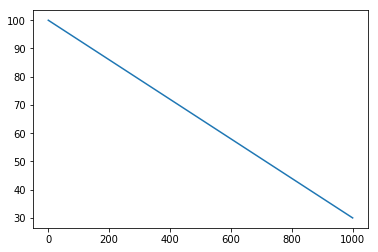

In [35]:
a = coeff[0]
b = coeff[1]
y = a*x + b
plt.plot(x,y)

In [ ]:
def get_lifetime(dic1,dic2,cap):
    
    D,C,F = partial_to_full(dic1,dic2)

    #For the prediction, get the full and partial curves
    
    Capacity = []
    Percent = []
    Time = []
    Slope = []
    Intercept = []
    Life = []
    for i in range(1,len(F)):
        capacity = dic2[F[i]]['discharge_ah'][dic2[F[i]].shape[0]]-dic2[F[i]]['discharge_ah'][0]
        percent = ((capacity - cap)/cap)*100
        time = dic1[C[i]]['time'][dic1[C[i]].shape[0]]
        #Coeff. for linear regression 
        coeff = np.polyfit([float(0),time],[float(100),percent],1)
        #Calculate the failure time
        life = -coeff[1]/coeff[0]
        
        Capacity.append(capacity)
        Percent.append(percent)
        Time.append(time)
        Slope.append(coeff[0])
        Intercep.append(coeff[1])
        Life.append(life)
    
    return Percent, Time, Slope, Intercept, Life

In [ ]:
def life_plot(time,slope,intercept,life):
    
    fig = plt.figure(figsize = (6, 6))
    x = [float(0),time]
    y = x*Slope + Intercept
    plt.plot(x,y)
    plt.scatter(time,life)
    x1 = [time,life]
    y1 = x1*slope + intercept
    plt.plot(x,y,ls = '--')
    return fig

In [36]:
def get_lifetime(dic1,dic2,cap):
    
    D,C,F = partial_to_full(dic1,dic2)

    #For the prediction, get the full and partial curves
    
    Full_cycles =np.zeros(len(F))
    for i in range (1,len(F)):
        Y[i] = F[i]
        
    a = pred[0]
    partial_curve = dic1[a]
    idx = np.argwhere(C == a)
    full_cycle = F[idx]
    
    #Calculate capacity 
    capacity = full_curve['discharge_ah'][full_curve.shape[0]]-full_curve['discharge_ah'][0] 
    
    percent = ((capacity - cap)/cap)*100
    
    time = partial_curve['time'][partial_curve.shape[0]]
    coeff = np.polyfit([float(0),time],[float(100),percent],1)
    
    life = -coeff[1]/coeff[0]
    
    fig = plt.figure(figsize = (6, 6))
    x = [float(0),time]
    y = x*coeff[0] + coeff[1]
    plt.plot(x,y)
    plt.scatter(time,life)
    x1 = [time,life]
    y1 = x1*coeff[0] + coeff[1]
    plt.plot(x,y,ls = '--')
    return percetn, life, fig
    